##I tried to do object localization on random pictures using Pokemon.Because my computer didn't fully support training, I had to decrease the size steps per epoch and number of epochs, therefore the localization didn't fully occur.If the number of epochs is 5 and size steps per epoch are 50, then it will be occur with highest learning rate.


In [1]:
import tensorflow as tf


In [2]:
import numpy as np
import imageio
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from tensorflow.keras.layers import Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from skimage.transform import resize

In [3]:
!ls

backgrounds	 bulbasaur-tight.png   __MACOSX     squirtle-tight.png
backgrounds.zip  charmander-tight.png  sample_data


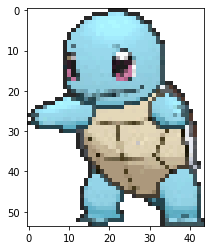

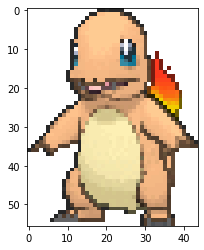

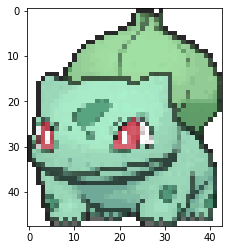

In [4]:
charmander = imageio.imread('charmander-tight.png')
bulbasaur = imageio.imread('bulbasaur-tight.png')
squirtle = imageio.imread('squirtle-tight.png')
plt.imshow(squirtle)
plt.show()
plt.imshow(charmander)
plt.show()
plt.imshow(bulbasaur)
plt.show()

In [5]:
POKEMON_DIM = 200
charmander = np.array(charmander)
bulbasaur = np.array(bulbasaur)
squirtle = np.array(squirtle)
CH_H, CH_W, CH_C = charmander.shape
BB_H, BB_W, BB_C = bulbasaur.shape
SQ_H, SQ_W, SQ_C = squirtle.shape
pokemon_data = [
                [charmander, CH_H, CH_W, CH_C],
                [bulbasaur, BB_H, BB_W, BB_C],
                [squirtle, SQ_H, SQ_W, SQ_C]
                ]
class_names = ['Charmander', 'Bulbasaur', 'Squirtle']

In [6]:
def loss(y_true, y_pred):
  bce = binary_crossentropy(y_true[:, :4], y_pred[:, :4])
  cce = categorical_crossentropy(y_true[:, 4:7], y_pred[:, 4:7])
  bce2 = binary_crossentropy(y_true[:, :-1], y_pred[:, :-1])

  return bce * y_true[:, -1] + cce * y_true[:, -1] + 0.5 * bce2


In [7]:

def make_model():
  vgg = tf.keras.applications.VGG16(
      input_shape = [POKEMON_DIM, POKEMON_DIM, 3],
      include_top = False,
      weights = 'imagenet')
  x = Flatten()(vgg.output)
  x1 = Dense(4, activation='sigmoid')(x)
  x2 = Dense(3, activation='softmax')(x)
  x3 = Dense(1, activation='sigmoid')(x)
  x = Concatenate()([x1, x2, x3])

  model = Model(vgg.input, x)
  model.compile(loss = loss, optimizer = Adam(lr=0.0001))

  return model

In [8]:
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip

File ‘backgrounds.zip’ already there; not retrieving.



In [9]:
!unzip -n backgrounds.zip

Archive:  backgrounds.zip


In [10]:
from glob import glob
backgrounds = []

background_files = glob('backgrounds/*.jpg')
for f in background_files:
  bg = np.array(image.load_img(f))
  backgrounds.append(bg)


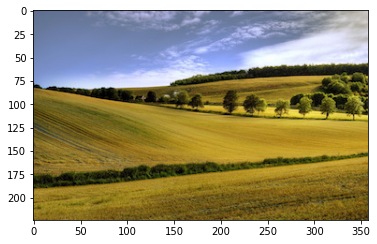

In [11]:
plt.imshow(backgrounds[3])

In [12]:
def pokemon_generator(batch_size = 64):
  while True:
    for _ in range(50):
      X = np.zeros((batch_size, POKEMON_DIM, POKEMON_DIM, 3))
      Y = np.zeros((batch_size, 8))

      for i in range(batch_size):
        bg_idx = np.random.choice(len(backgrounds))
        bg = backgrounds[bg_idx]
        bg_h, bg_w, _ = bg.shape
        rnd_h = np.random.randint(bg_h - POKEMON_DIM)
        rnd_w = np.random.randint(bg_w - POKEMON_DIM) 
        X[i] = bg[rnd_h:rnd_h + POKEMON_DIM, rnd_w:rnd_w + POKEMON_DIM].copy()

        appear = (np.random.random() < 0.75)
        if appear:
          pk_idx = np.random.randint(3)
          pk, h, w, _ = pokemon_data[pk_idx]

          scale = 0.5 + np.random.random()
          new_height = int(h * scale)
          new_width = int(w * scale)

          obj = resize(
              pk,
              (new_height, new_width),
              preserve_range=True).astype(np.uint8)

          if np.random.random() < 0.5:
            obj = np.fliplr(obj)

          row0 = np.random.randint(POKEMON_DIM - new_height)
          col0 = np.random.randint(POKEMON_DIM - new_width) 
          row1 = row0 + new_height
          col1 = col0 + new_width

          mask = (obj[:,:,3] == 0)
          bg_slice = X[i, row0:row1, col0:col1,:]
          bg_slice = np.expand_dims(mask, -1) * bg_slice
          bg_slice += obj[:,:,:3]
          X[i, row0:row1, col0:col1,:] = bg_slice

          Y[i,0] = row0/POKEMON_DIM
          Y[i,1] = col0/POKEMON_DIM
          Y[i,2] = (row1 - row0)/POKEMON_DIM
          Y[i,3] = (col1 - col0)/POKEMON_DIM

          Y[i, 4 + pk_idx] = 1

        Y[i,7] = appear

      yield  X / 255., Y




      

In [13]:
xx = None
yy = None

for x,y in pokemon_generator():
  xx,yy = x,y
  break

[0.22  0.365 0.325 0.29  0.    1.    0.    1.   ]
Percent number of object:  0.15625
Percent of Charmander:  0.265625
Percent of Bulbasaur:  0.265625
Percent of Squirter:  0.3125


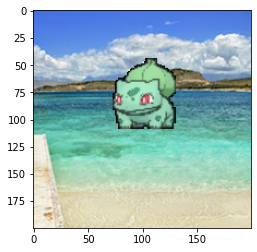

In [14]:
n = yy.shape[0]
idx = np.random.randint(n)
plt.imshow(xx[idx]);
print(yy[idx])
print("Percent number of object: ", (yy[:,7] == 0).sum() / n)
print("Percent of Charmander: ", yy[:,4].sum() / n)
print("Percent of Bulbasaur: ", yy[:,5].sum() / n)
print("Percent of Squirter: ", yy[:,6].sum() / n)




In [15]:
model = make_model()
model.fit_generator(
    pokemon_generator(),
    steps_per_epoch = 10,
    epochs = 3,)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/3
10/10 [==============================] - 950s 95s/step - loss: 1.5800
Epoch 2/3
10/10 [==============================] - 965s 97s/step - loss: 1.0087
Epoch 3/3
10/10 [==============================] - 938s 94s/step - loss: 0.6673


In [25]:
def pokemon_prediction():
  bg_idx = np.random.choice(len(backgrounds))
  bg = backgrounds[bg_idx]
  bg_h, bg_w, _ = bg.shape
  rnd_h = np.random.randint(bg_h - POKEMON_DIM)
  rnd_w = np.random.randint(bg_w - POKEMON_DIM)
  x = bg[rnd_h:rnd_h + POKEMON_DIM, rnd_w:rnd_w + POKEMON_DIM].copy()

  appear = (np.random.random() < 0.75)
  if appear:
    pk_idx = np.random.randint(3)
    pk, h, w, _ = pokemon_data[pk_idx]

    scale = 0.5 + np.random.random()
    new_height = int(h * scale)
    new_width = int(w * scale)

    obj = resize(
        pk,
        (new_height, new_width),
        preserve_range=True).astype(np.uint8)

    if np.random.random() < 0.5:
      obj = np.fliplr(obj)

    row0 = np.random.randint(POKEMON_DIM - new_height)
    col0 = np.random.randint(POKEMON_DIM - new_width) 
    row1 = row0 + new_height
    col1 = col0 + new_width

    mask = (obj[:,:,3] == 0)
    bg_slice = x[row0:row1, col0:col1,:]
    bg_slice = np.expand_dims(mask, -1) * bg_slice
    bg_slice += obj[:,:,:3]
    x[row0:row1, col0:col1,:] = bg_slice  
    actual_class = class_names[pk_idx]
    print("True: ", row0, col0, row1, col1, actual_class)

    X = np.expand_dims(x,0) / 255.
    p = model.predict(X)[0] 

    fig, ax = plt.subplots(1)
    ax.imshow(x.astype(np.uint8))

    if p[-1] > 0.5:
      row0 = int(p[0] * POKEMON_DIM)
      col0 = int(p[1] * POKEMON_DIM)
      row1 = int(row0 + p[2] * POKEMON_DIM)
      col1 = int(col0 + p[3] * POKEMON_DIM)

      class_pred_idx = np.argmax(p[4:7])
      class_pred = class_names[class_pred_idx]
      print("Prediction: ", row0, col0, row1, col1,class_pred)

      rect = Rectangle(
          (p[1] * POKEMON_DIM, p[0] * POKEMON_DIM),
          p[3] * POKEMON_DIM, p[2] * POKEMON_DIM, linewidth = 1, edgecolor= 'r', facecolor = 'none')
      ax.add_patch(rect)

    else:
      print("Prediction: No object.")

    plt.show()  


True:  110 68 188 129 Charmander
Prediction: No object.


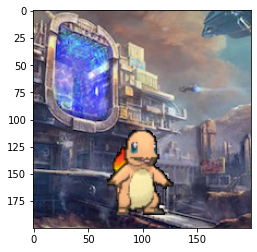

In [35]:
pokemon_prediction()

True:  135 21 199 73 Squirtle
Prediction:  116 3 134 39 Squirtle


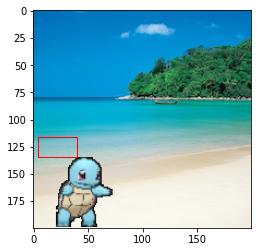

In [41]:
pokemon_prediction()

True:  114 116 151 149 Bulbasaur
Prediction:  125 73 178 127 Bulbasaur


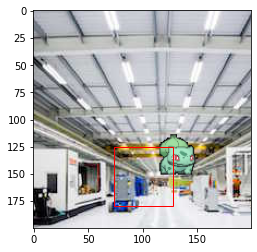

In [29]:
pokemon_prediction()

True:  83 83 111 105 Charmander
Prediction:  57 71 86 95 Charmander


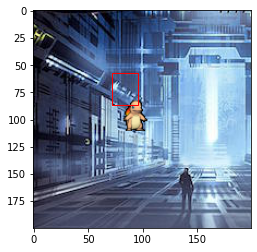

In [50]:
pokemon_prediction()

True:  129 41 175 77 Charmander
Prediction: No object.


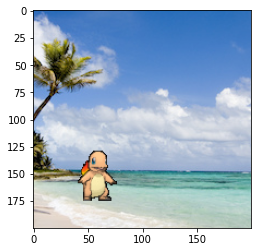

In [38]:
pokemon_prediction()